In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Import local modules
import sys
import os
sys.path.append(os.path.abspath('.'))
from load_data import load_preprocessed_data
from evaluation import compare_models, summarize_comparison, evaluate_model

In [2]:
def hhmm_to_minutes(time_val):
    if pd.isna(time_val):
        return np.nan
    try:
        if isinstance(time_val, str) and ':' in time_val:
            parts = time_val.split(':')
            hour = int(parts[0])
            minute = int(parts[1])
            if hour == 24:
                return 0
            return hour * 60 + minute
        s = str(int(float(time_val))).zfill(4)
        if s == '2400':
            return 0
        hour = int(s[:2])
        minute = int(s[2:])
        return hour * 60 + minute
    except (ValueError, TypeError, IndexError):
        return np.nan


class FlightDataPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.categorical_cols = ['op_unique_carrier', 'origin', 'dest']
        self.cols_to_drop = ['origin_city_name', 'origin_state_nm', 'dest_city_name', 'dest_state_nm']

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()

        cols_to_drop_existing = [col for col in self.cols_to_drop if col in X_copy.columns]
        if cols_to_drop_existing:
            X_copy = X_copy.drop(columns=cols_to_drop_existing)

        if 'dep_time' in X_copy.columns:
            X_copy['dep_time_minutes'] = X_copy['dep_time'].apply(hhmm_to_minutes)
            X_copy['dep_time_sin'] = np.sin(2 * np.pi * X_copy['dep_time_minutes'] / 1440.0)
            X_copy['dep_time_cos'] = np.cos(2 * np.pi * X_copy['dep_time_minutes'] / 1440.0)
            X_copy = X_copy.drop(columns=['dep_time', 'dep_time_minutes'])

        if 'month' in X_copy.columns:
            X_copy['month_sin'] = np.sin(2 * np.pi * X_copy['month'] / 12.0)
            X_copy['month_cos'] = np.cos(2 * np.pi * X_copy['month'] / 12.0)
            X_copy = X_copy.drop(columns=['month'])

        if 'day_of_week' in X_copy.columns:
            X_copy['day_of_week_sin'] = np.sin(2 * np.pi * X_copy['day_of_week'] / 7.0)
            X_copy['day_of_week_cos'] = np.cos(2 * np.pi * X_copy['day_of_week'] / 7.0)
            X_copy = X_copy.drop(columns=['day_of_week'])

        if 'day_of_month' in X_copy.columns:
            X_copy['day_of_month_sin'] = np.sin(2 * np.pi * X_copy['day_of_month'] / 31.0)
            X_copy['day_of_month_cos'] = np.cos(2 * np.pi * X_copy['day_of_month'] / 31.0)
            X_copy = X_copy.drop(columns=['day_of_month'])

        for col in self.categorical_cols:
            if col in X_copy.columns:
                X_copy[col] = X_copy[col].astype('category')

        return X_copy


class XGBoostThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, threshold=0.4125):
        self.threshold = threshold
        self.preprocessor = FlightDataPreprocessor()

        best_params = {
            'colsample_bytree': 0.7211248392548631,
            'gamma': 0.10445935880768009,
            'learning_rate': 0.14422870336481014,
            'max_depth': 11,
            'n_estimators': 838,
            'reg_alpha': 0.5183296523637367,
            'reg_lambda': 4.509492287711822,
            'subsample': 0.9222305853262613
        }

        self.model = XGBClassifier(
            tree_method='gpu_hist',
            predictor='gpu_predictor',
            enable_categorical=True,
            random_state=42,
            n_jobs=-1,
            **best_params
        )

    def fit(self, X, y):
        X_processed = self.preprocessor.fit_transform(X)

        negative_count = len(y) - sum(y)
        positive_count = sum(y)
        if positive_count > 0:
            scale_pos_weight = sqrt(negative_count / positive_count)
        else:
            scale_pos_weight = 1

        self.model.set_params(scale_pos_weight=scale_pos_weight)

        self.model.fit(X_processed, y)
        self.classes_ = self.model.classes_ # Expose classes_ for sklearn compatibility
        return self

    def predict_proba(self, X):
        X_processed = self.preprocessor.transform(X)
        return self.model.predict_proba(X_processed)

    def predict(self, X):
        probas = self.predict_proba(X)
        return (probas[:, 1] >= self.threshold).astype(int)

    def save_model(self, path):
        import joblib
        joblib.dump(self, path)

    @staticmethod
    def load_model(path):
        import joblib
        return joblib.load(path)

In [3]:
class TypeConverter(BaseEstimator, TransformerMixin):
    """
    Helper transformer to convert categorical columns (from FlightDataPreprocessor)
    into numeric codes for Scikit-Learn models (RF, NB, SVM).
    """
    def __init__(self, cat_cols):
        self.cat_cols = cat_cols
        self.encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

    def fit(self, X, y=None):
        # X is output of FlightDataPreprocessor (DataFrame)
        # Convert cats to string to fit OrdinalEncoder
        self.encoder.fit(X[self.cat_cols].astype(str))
        return self

    def transform(self, X):
        X = X.copy()
        X[self.cat_cols] = self.encoder.transform(X[self.cat_cols].astype(str))
        return X

In [4]:
# Load Data
X, y = load_preprocessed_data()

# Sample for model comparison
# SVM is computationally expensive, so we use a smaller sample for it.
# Other models can handle larger datasets.

SAMPLE_LARGE = 1_000_000
SAMPLE_SMALL = 50_000

print(f"Sampling {SAMPLE_LARGE} rows for general models...")
X_large = X.sample(n=SAMPLE_LARGE, random_state=42)
y_large = y.loc[X_large.index]

print(f"Sampling {SAMPLE_SMALL} rows for SVM...")
# We sample from the large set to ensure it's a subset (optional, but good for consistency)
# or just sample from X again. Let's sample from X to be independent or X_large to be subset.
# Sampling from X directly is fine.
X_small = X.sample(n=SAMPLE_SMALL, random_state=42)
y_small = y.loc[X_small.index]

print("Large sample shape:", X_large.shape)
print("Small sample shape:", X_small.shape)

📂 Loading data from: ../../data/preprocessed_flight_data.csv
Sampling 1000000 rows for general models...
Sampling 50000 rows for SVM...
Large sample shape: (1000000, 12)
Small sample shape: (50000, 12)


In [5]:
# Define Best Parameters
rf_params = {
    'bootstrap': True,
    'max_depth': 15,
    'max_features': 'sqrt',
    'min_samples_leaf': 4,
    'min_samples_split': 9,
    'n_estimators': 251,
    'n_jobs': -1,
    'random_state': 42
}

nb_params = {
    'var_smoothing': 1.4610865886287194e-10
}

svm_params = {
    'C': 92.93816178430156,
    'gamma': 0.001444819600787046,
    'class_weight': 'balanced',
    'kernel': 'rbf',
    'probability': True,  # Needed for ROC/PR AUC
    'random_state': 42
}

cat_cols = ['op_unique_carrier', 'origin', 'dest']

# Construct Pipelines
rf_pipeline = Pipeline([
    ('preproc', FlightDataPreprocessor()),
    ('encoder', TypeConverter(cat_cols)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('rf', RandomForestClassifier(**rf_params))
])

nb_pipeline = Pipeline([
    ('preproc', FlightDataPreprocessor()),
    ('encoder', TypeConverter(cat_cols)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('nb', GaussianNB(**nb_params))
])

svm_pipeline = Pipeline([
    ('preproc', FlightDataPreprocessor()),
    ('encoder', TypeConverter(cat_cols)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('svm', SVC(**svm_params))
])

xgb_model = XGBoostThresholdClassifier()

# Reordered models dictionary to run XGBoost first
models = {
    'XGBoost': xgb_model,
    'Random Forest': rf_pipeline,
    'Naive Bayes': nb_pipeline,
    'SVM': svm_pipeline
}

Starting model evaluation (cross-validation)...
Evaluating: XGBoost...


/home/adam/anaconda3/envs/flight-delay/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:02:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/adam/anaconda3/envs/flight-delay/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:02:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/adam/anaconda3/envs/flight-delay/lib/python3.13/site-packages/xgboost/core.py:2676: UserWarning: [15:03:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

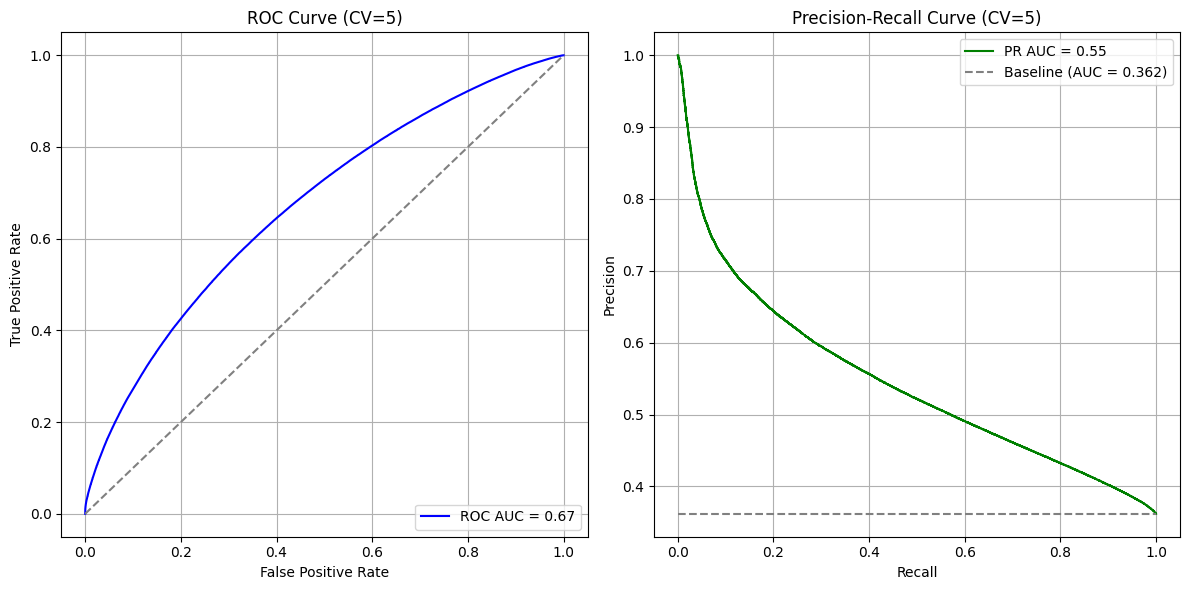

Completed: XGBoost
Evaluating: Random Forest...


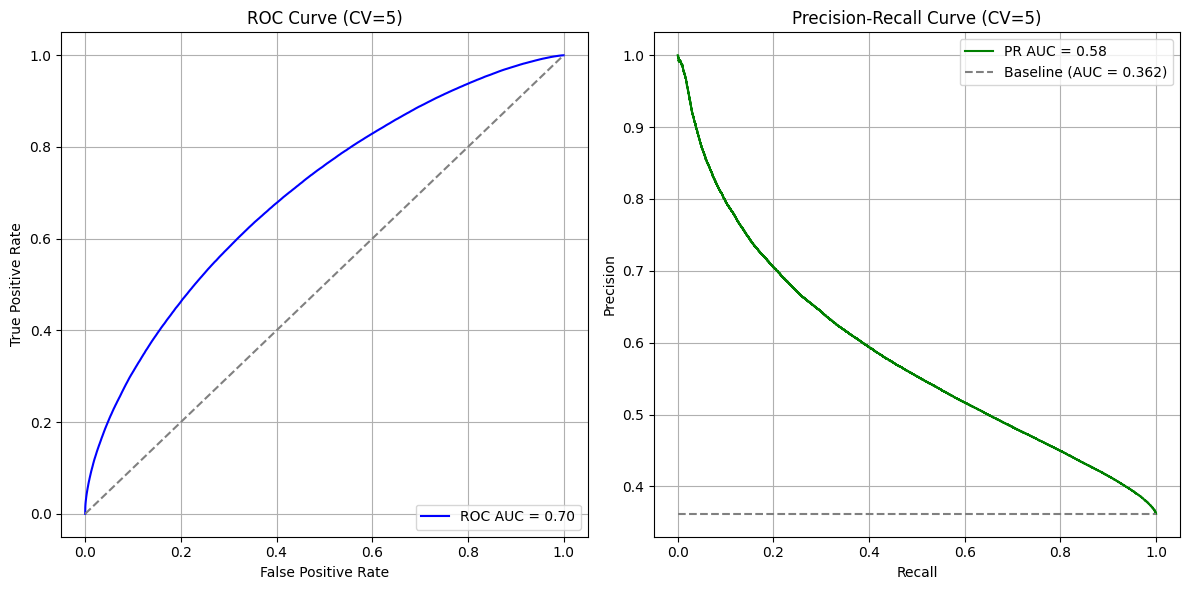

Completed: Random Forest
Evaluating: Naive Bayes...


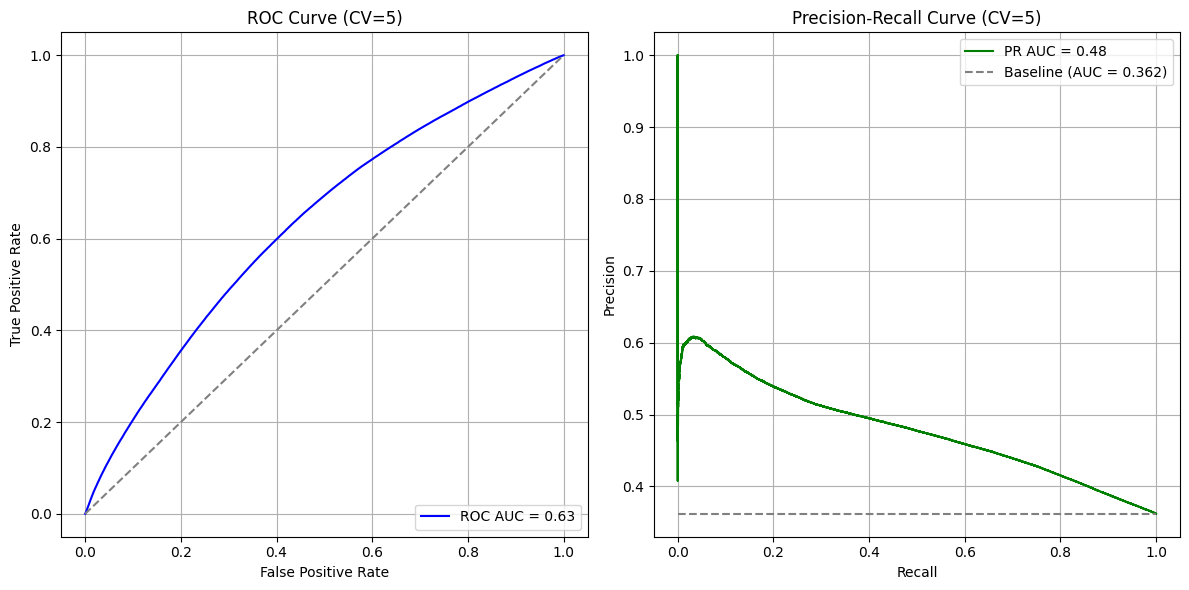

Completed: Naive Bayes
Evaluating: SVM...
  -> Using override dataset (50000 samples)


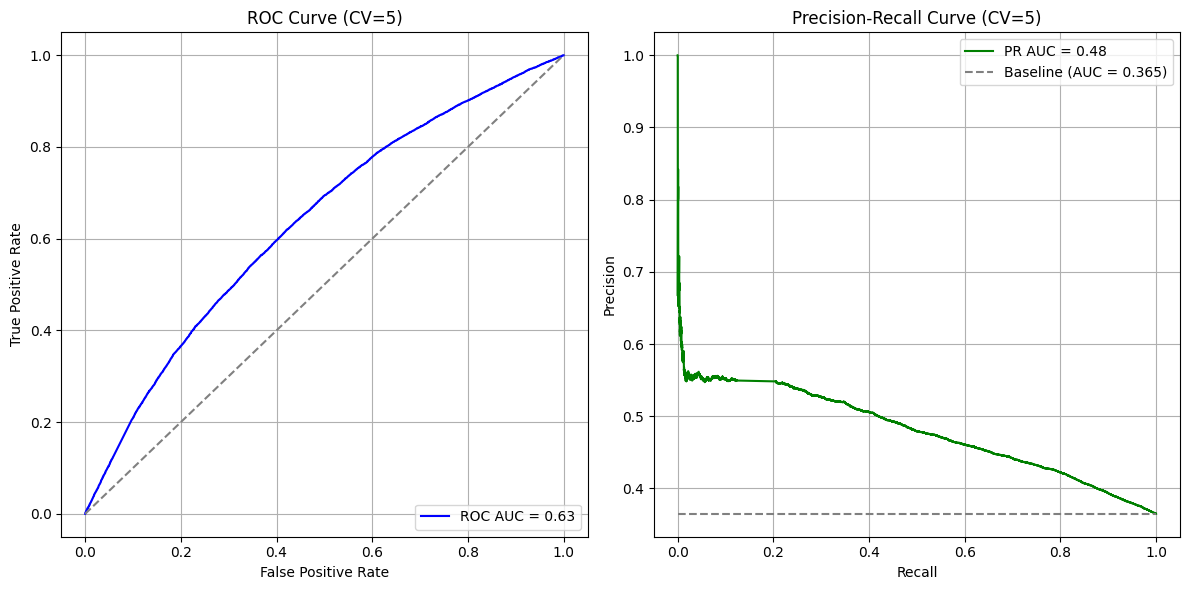

Completed: SVM
Evaluation finished.


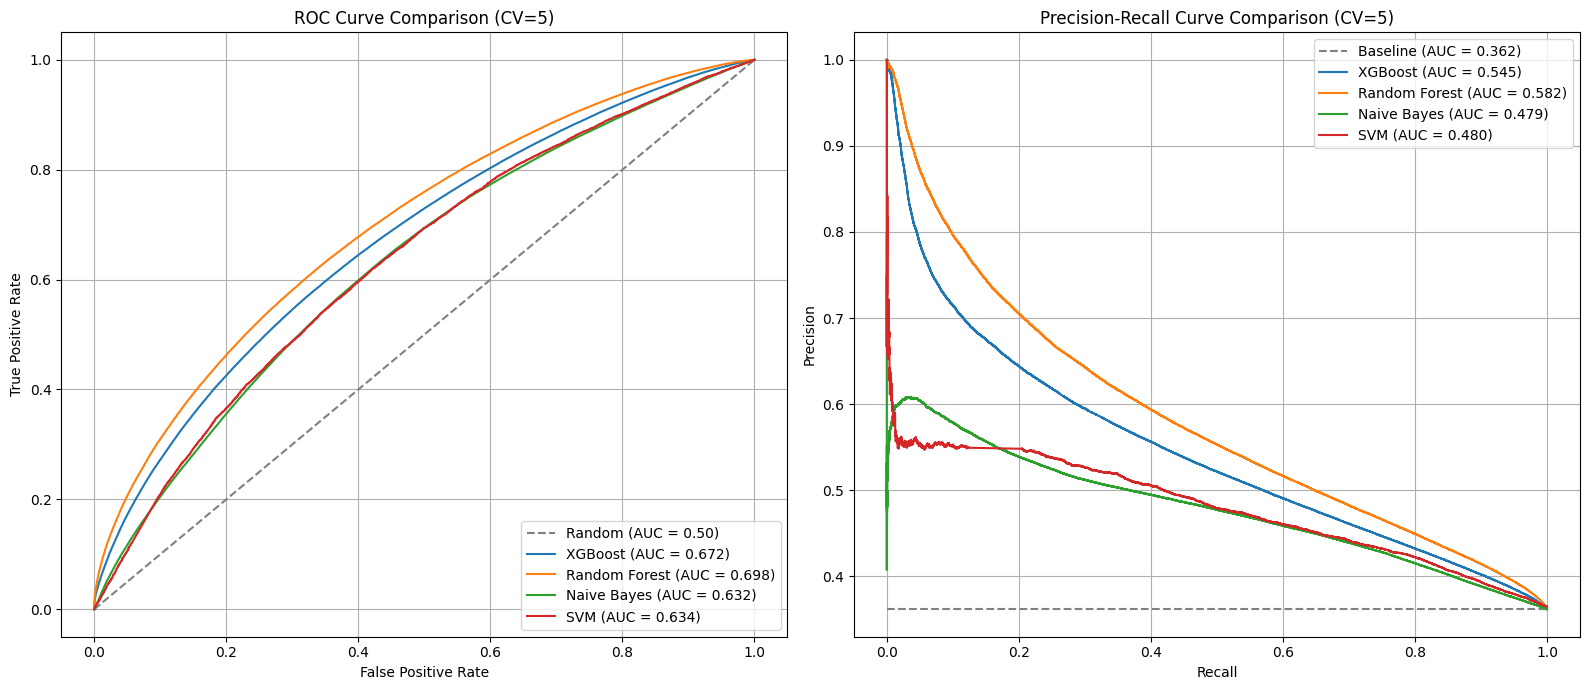

In [6]:
# Reload evaluation module to ensure we have the updated compare_models function
import evaluation
import importlib
importlib.reload(evaluation)
from evaluation import compare_models

# Run Comparison
# We pass the large dataset as default, and override SVM with the small dataset
overrides = {
    'SVM': (X_small, y_small)
}

results = compare_models(models, X_large, y_large, cv=5, data_overrides=overrides)

In [7]:
# Reload evaluation module to ensure we have the updated summarize_comparison function
import evaluation
import importlib
importlib.reload(evaluation)
from evaluation import summarize_comparison

# Summarize Results
df_summary = summarize_comparison(results)
df_summary

,Accuracy,ROC AUC,PR AUC,Precision (Class +),Recall (Class +),F1-score (Class +)
Model,,,,,,
XGBoost,0.6284,0.6718,0.5455,0.4891,0.6054,0.5411
Random Forest,0.6852,0.6979,0.5820,0.6602,0.2681,0.3813
Naive Bayes,0.6445,0.6324,0.4787,0.5161,0.2814,0.3642
SVM,0.5836,0.6344,0.4801,0.4510,0.6506,0.5327
